In [1]:
import numpy as np
import xarray as xr
import rasterio as rio
import rioxarray
import matplotlib.pyplot as plt
import xdem 

In [2]:
data_path = '/mnt/Backups/gbrench/repos/rg_uavsar/data'

# open data 
ds = xr.open_dataset(f'{data_path}/combined/stack_20230725_20230925.zarr', chunks='auto', engine='zarr')
ds = ds.rio.write_crs('EPSG:32613')

ns_da = xr.open_dataarray(f'{data_path}/combined/ns_disp.tif').squeeze()
ew_da =xr.open_dataarray(f'{data_path}/combined/ew_disp.tif').squeeze()
ud_da =xr.open_dataarray(f'{data_path}/combined/ud_disp.tif').squeeze()

ds['ns_displacement'] = (('y', 'x'), ns_da.values)
ds['ew_displacement'] = (('y', 'x'), ew_da.values)
ds['ud_displacement'] = (('y', 'x'), ud_da.values)

In [3]:
ds['total_displacement'] = np.sqrt(ds.ns_displacement**2 + ds.ew_displacement**2 + ds.ud_displacement**2)

In [4]:
ds['elevation'] = ds.height.mean(dim='swatch')

In [5]:
transform = (5.322144725472049309, 0.0, ds.elevation.isel(x=0, y=0).x.item(), 0.0, 5.322144725472049309, ds.elevation.isel(x=0, y=0).x.item())
# load to xdem
dem = xdem.DEM.from_array(ds.elevation.values, transform, crs='EPSG:32613')
# calculate slope 
ds['slope'] = (('y', 'x'), xdem.terrain.slope(dem).data.data)

/mnt/Backups/gbrench/sw/miniconda3/envs/insar/lib/python3.11/site-packages/geoutils/raster/raster.py:1891: UserWarning: Setting default nodata -99999 to mask non-finite values found in the array, as no nodata value was defined.
  warnings.warn(


In [6]:
n=3 # Glen's flow law exponent
A = 9.461999999999998e-17 # rheology constant for temperate glaciers (Pa^-3/yr), (3*10**-24)*(3.154e7)
rho_i = 917 # density of ice (kg/m^3)
rho_d = 2650 # density of rock debris (kg/m^3)
rho_m = rho_d*0.5 + rho_i*0.5 # assuming half and half ice and rock and no pore space
g = 9.81 # acceleration due to gravity (m/s^2) 

# starting with eq 2 from Millan et al. 2022 https://www.nature.com/articles/s41561-021-00885-z
ds['thickness'] = ((((ds.total_displacement/62)*365.25)*(n+1))/((2*A*(rho_m*g)**n)*ds.slope**n))**(1/(n+1))

In [7]:
ds.thickness.rio.to_raster(f'{data_path}/combined/glens_thickness.tif', compress='LZW')

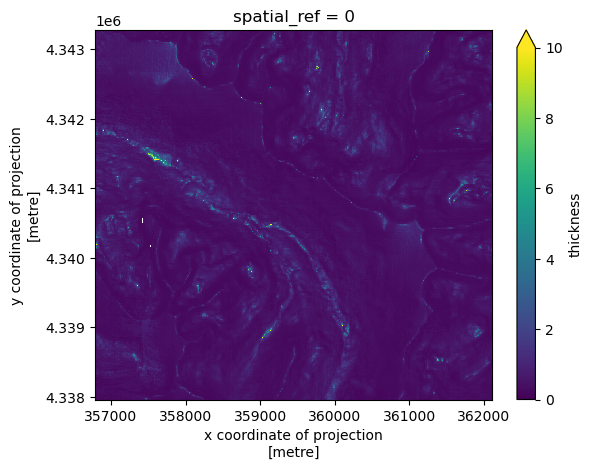

In [8]:
my_slice = ds.isel(x=slice(3000, 4000), y=slice(3000, 4000))
f, ax = plt.subplots()
my_slice.thickness.plot(ax=ax, vmin=0, vmax=10)